In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import hamhelper.plotting as hp

Solution successful for tau = 6.283185307179586


<Figure size 1000x400 with 0 Axes>

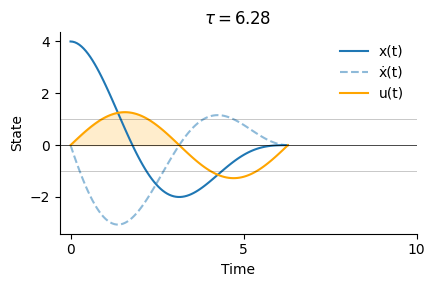

Solution successful for tau = 7.5


<Figure size 1000x400 with 0 Axes>

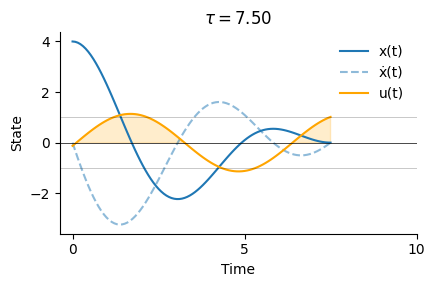

Solution successful for tau = 11


<Figure size 1000x400 with 0 Axes>

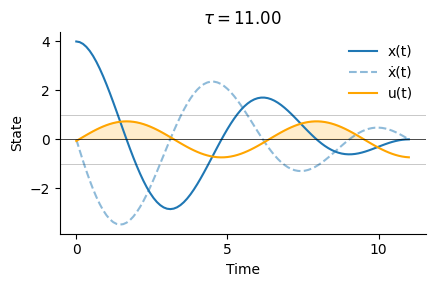

In [ ]:
# Define the ODE system
def dynamics(t, y):
    # From part (b)
    x1, x2, l1, l2 = y
    dx1dt =     x2
    dx2dt = -x1       - l2
    dl1dt =        l2
    dl2dt =           - l1
    return np.array([dx1dt, dx2dt, dl1dt, dl2dt])

def boundary_cond(ya, yb):
    x1a, x2a, _, _ = ya  # Using x and x' not lambdas
    x1b, x2b, _, _ = yb
    return np.array([
        x1a - 4,    # x1(0) = x0 = 4  initial
        x2a - 0,    # x2(0) = 0
        x1b - 0,    # x1(tau) = 0     final
        x2b - 0])   # x2(tau) = 0
    

# Initial mesh and guess
def solve_for_tau(tau):
    t = np.linspace(0, tau, 100)
    y_guess = np.zeros((4, t.size))
    y_guess[0] = 0  # super crude y=const guess

    # Solve BVP
    sol = solve_bvp(dynamics, boundary_cond, t, y_guess)
    if sol.success:
        print(f"Solution successful for tau = {tau:.2f}")
    else:
        print("Solution failed. Fix me!")

    return sol

# Example for τ = 2π
taus = [2 * np.pi, 7.5, 11]

for tau in taus:
    sol = solve_for_tau(tau)

    # Extract solution
    t_vals = sol.x
    x1, x2, l1, l2 = sol.y
    u = -l2

    # Plotting
    plt.figure(figsize=(10, 4))
    fig, ax = plt.subplots(1, 1, figsize=np.array([3.3, 2.2])*1.35)
    ax.plot(t_vals, x1, label='x(t)', color='C0')
    ax.plot(t_vals, x2, label='ẋ(t)', color='C0', linestyle='--', alpha=0.5)
    ax.plot(t_vals, u, color='orange', label='u(t)')
    ax.fill_between(t_vals, u, 0, where=u > 0, color='orange', alpha=0.2)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.axhline(1, color='k', lw=0.5, alpha=0.3)
    ax.axhline(-1, color='k', lw=0.5, alpha=0.3)
    
    ax.set(xlabel='Time', ylabel='State', title=r'$\tau = $' + f'{tau:.2f}',
           xticks=[0, 5, 10],)
    hp.despine(ax)
    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.savefig(f'plots/q1_c_tau_{tau:.2f}.pdf', bbox_inches='tight')
    plt.savefig(f'plots/q1_c_tau_{tau:.2f}.png', bbox_inches='tight')
    plt.show()